## Importing Necessary Libraries

#### Selenium WebDriver imports for browser automation.

In [143]:
from selenium import webdriver  # Core web driver from the Selenium package, used for browser automation.
from selenium.webdriver.edge.service import Service  # Edge-specific service to interact with the Edge browser.
from selenium.webdriver.common.keys import Keys  # For simulating keyboard strokes.
from selenium.webdriver.common.by import By  # For locating elements within a webpage.
from selenium.common.exceptions import NoSuchElementException  # Exception handling for non-existent elements.
from msedge.selenium_tools import Edge, EdgeOptions  # Enhanced tools for Microsoft Edge browser automation.

#### Standard Python libraries for regex, time handling, and datetime.

In [144]:
import re  # Regular expressions library for string searching and manipulation.
import time  # Time handling (e.g., sleep/delays) during web scraping.
from datetime import datetime  # Handling and formatting dates and times.

#### Pandas for data manipulation and analysis.

In [145]:
import pandas as pd
pd.set_option("future.no_silent_downcasting", True)  # Configuration setting for pandas

#### NLTK (Natural Language Toolkit) for natural language processing tasks.

In [146]:
import nltk
from nltk.corpus import stopwords  # To access a list of 'stopwords'

#### Plotly Express and Matplotlib for data visualization.

In [147]:
import plotly.express as px
import matplotlib.pyplot as plt

#### WordCloud for generating word cloud visualizations.

In [148]:
from wordcloud import WordCloud

## Configuring URL to be scraped

In [149]:
# Game ID to be scraped, found in URL
game_id = 1245620 # Elden Ring
# URL containing most recent and english filters
url_template = "https://steamcommunity.com/app/{}/reviews/?p=1&browsefilter=mostrecent&filterLanguage=english"
url = url_template.format(game_id)
print(url)

https://steamcommunity.com/app/1245620/reviews/?p=1&browsefilter=mostrecent&filterLanguage=english


## Initializing Selenium WebDriver for Microsoft Edge

In [150]:
service = Service()
options = webdriver.EdgeOptions()

language = "en-US"
options.add_argument(f"--lang={language}")

driver = webdriver.Edge(service=service, options=options)
driver.maximize_window()
driver.get(url)

## Helper Functions for Web Scraping

In [151]:
# Get current position on web page
def get_current_scroll_position(driver):
    return driver.execute_script("return window.pageYOffset;")
    
# Scroll to the bottom of the page (position 0) 
def scroll_to_bottom(driver):
    driver.execute_script("window.scrollTo(20, document.body.scrollHeight);") # Used 20 instead of 0 to save time
    time.sleep(1) # Allow reviews to load

# Retreive steam id from review card
def get_steam_id(card):
    # Locates the user's profile URL within the review card. 
    # This is done by finding an anchor (`a`) element using its XPATH, which points to the user's Steam profile.
    profile_url = card.find_element(By.XPATH, './/div[@class="apphub_friend_block"]/div/a[2]').get_attribute('href')

    # Extracts the Steam ID from the profile URL.
    # The Steam ID is assumed to be the second to last segment in the URL, which is why `split('/')[-2]` is used.
    steam_id = profile_url.split('/')[-2]

    # Returns the extracted Steam ID.
    return steam_id
    
# Retreive review data from review card
def scrape_review_data(card):
    # Extracts the date when the review was posted. It locates the element by XPATH and retrieves its text content.
    date_posted_element = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]/div[@class="date_posted"]')
    date_posted = date_posted_element.text.strip()

    # Extracts the main content of the review. It finds the element containing the review text by its class name.
    card_text_content_element = card.find_element(By.CLASS_NAME, "apphub_CardTextContent")
    review_content = card_text_content_element.text.strip()

    # Removes any extraneous elements from the review content, in this case, the date posted.
    excluded_elements = [date_posted]
    for excluded_element in excluded_elements:
        review_content = review_content.replace(excluded_element, "")

    # Removes newline characters from the review content for consistency.
    review_content = review_content.replace("\n", "")

    # Calculates the length of the review by counting the number of characters excluding spaces.
    review_length = len(review_content.replace(" ", ""))

    # Extracts the thumb text (like/dislike or similar indicator) from the review.
    thumb_text = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[2]').text

    # Extracts the number of hours played which is typically mentioned in the review.
    play_hours = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[3]').text

    # Returns a tuple containing the extracted data: review content, thumb text, review length, play hours, and the date posted.
    return review_content, thumb_text, review_length, play_hours, date_posted

## Scraping Reviews from Steam

In [152]:
# Initialize an empty list to store review data and a set to store unique Steam IDs.
reviews = []
steam_ids_set = set()

# Define the maximum number of attempts to scroll the page.
max_scroll_attempts = 5

try:
    # Get the initial scroll position on the webpage.
    last_position = get_current_scroll_position(driver)
    running = True

    # Start a loop to iterate through the review cards on the page.
    while running:
        # Find all review card elements on the page.
        cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')

        # Iterate through the last 20 cards loaded on the page.
        for card in cards[-20:]:
            # Extract the Steam ID from each card.
            steam_id = get_steam_id(card)

            # Check if this Steam ID has already been processed.
            if steam_id in steam_ids_set:
                continue
            else:
                # Scrape review data from the card.
                review = scrape_review_data(card)
                # Add the scraped data to the reviews list.
                reviews.append(review)

        # Scroll management to load new cards.
        scroll_attempt = 0
        while scroll_attempt < max_scroll_attempts:
            # Scroll to the bottom of the page to load new cards.
            scroll_to_bottom(driver)
            # Get the current scroll position.
            curr_position = get_current_scroll_position(driver)

            # Check if the scroll position has not changed.
            if curr_position == last_position:
                # Increment the scroll attempt counter.
                scroll_attempt += 1
                # Wait for a bit to allow the page to load.
                time.sleep(3)

                # Check if maximum scroll attempts have been reached.
                if curr_position >= 3:
                    # Stop running if new cards are not loading.
                    running = False
                    break
            else:
                # Update the last scroll position.
                last_position = curr_position
                break

# Handle any exceptions that occur during the scraping process.
except Exception as e:
    print(e)

# Ensure that the browser is closed after scraping is done.
finally:
    driver.quit()

## Creating and Displaying Scraped Data Frame

In [153]:
df = pd.DataFrame(reviews, columns= ['ReviewText', 'Review', 'ReviewLength', 'PlayHours', 'DatePosted'])

In [154]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,"I really like this game, Your should try it if...",Recommended,143,49.0 hrs on record,Posted: March 31
1,Top 10 greatest games of all time,Recommended,27,238.0 hrs on record,Posted: March 31
2,Stressful addiction,Recommended,18,11.7 hrs on record,Posted: March 31
3,very unforgiving but that is to be expected,Recommended,36,26.6 hrs on record,Posted: March 31
4,peak gaming,Recommended,10,9.3 hrs on record,Posted: March 31


## Generating pie chart using Plotly Express
The pie chart represents the distribution of different review types

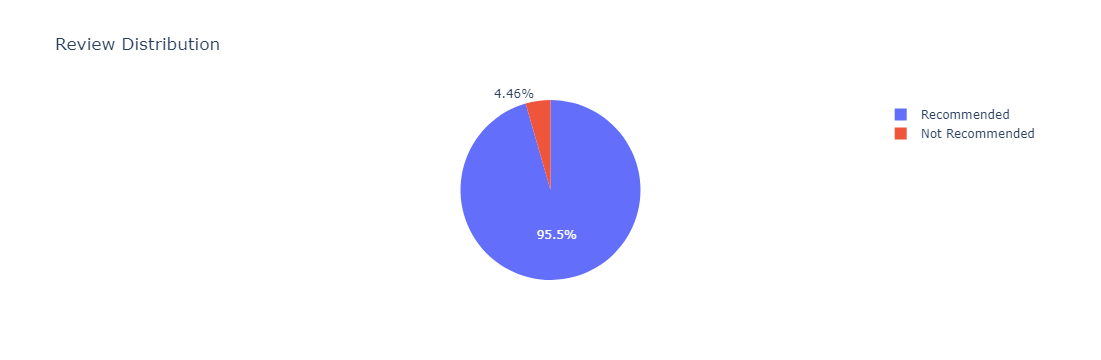

In [155]:
review_counts = df['Review'].value_counts()
px.pie(
    review_counts,        # The data source for the pie chart.
    values=review_counts, # The values that each slice of the pie chart will represent.
    names=review_counts.index, # The names of each slice, corresponding to the review types.
    title='Review Distribution' # The title of the pie chart.
)

## Data Cleaning and Transformation

### Removing unnecessary text from PlayHours

In [156]:
df['PlayHours'] = df['PlayHours'].map(lambda x: re.sub(' hrs on record', '', x))
df['PlayHours'] = df['PlayHours'].map(lambda x: re.sub(',', '', x)).astype(float)

In [157]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,"I really like this game, Your should try it if...",Recommended,143,49.0,Posted: March 31
1,Top 10 greatest games of all time,Recommended,27,238.0,Posted: March 31
2,Stressful addiction,Recommended,18,11.7,Posted: March 31
3,very unforgiving but that is to be expected,Recommended,36,26.6,Posted: March 31
4,peak gaming,Recommended,10,9.3,Posted: March 31


### Remove unnecessary text from DatePosted

In [158]:
df['DatePosted'] = df['DatePosted'].map(lambda x: re.sub('Posted: ', '', x))

In [159]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,"I really like this game, Your should try it if...",Recommended,143,49.0,March 31
1,Top 10 greatest games of all time,Recommended,27,238.0,March 31
2,Stressful addiction,Recommended,18,11.7,March 31
3,very unforgiving but that is to be expected,Recommended,36,26.6,March 31
4,peak gaming,Recommended,10,9.3,March 31


### Mapping month names to numerical representations

In [160]:
month_mapping = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}

### Separating Month and Day from DatePosted

In [161]:
df[['Month', 'Day']] = df['DatePosted'].str.extract(r'(\w+) (\d+)', expand=True)

In [162]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Month,Day
0,"I really like this game, Your should try it if...",Recommended,143,49.0,March 31,March,31
1,Top 10 greatest games of all time,Recommended,27,238.0,March 31,March,31
2,Stressful addiction,Recommended,18,11.7,March 31,March,31
3,very unforgiving but that is to be expected,Recommended,36,26.6,March 31,March,31
4,peak gaming,Recommended,10,9.3,March 31,March,31


### Mapping corresponding Month and Day

In [163]:
df['Month'] = df['Month'].map(month_mapping)

In [164]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Month,Day
0,"I really like this game, Your should try it if...",Recommended,143,49.0,March 31,03,31
1,Top 10 greatest games of all time,Recommended,27,238.0,March 31,03,31
2,Stressful addiction,Recommended,18,11.7,March 31,03,31
3,very unforgiving but that is to be expected,Recommended,36,26.6,March 31,03,31
4,peak gaming,Recommended,10,9.3,March 31,03,31


### Converting DatePosted into a standard format, drop unnecessary Month and Day columns

In [165]:
df['DatePosted'] = df['Month'] + '/' + df['Day'] + '/2024'
df['DatePosted'] = pd.to_datetime(df['DatePosted'], format='%m/%d/%Y').dt.strftime('%m-%d-%Y')
df = df.drop(['Month', 'Day'], axis=1)

In [166]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,"I really like this game, Your should try it if...",Recommended,143,49.0,03-31-2024
1,Top 10 greatest games of all time,Recommended,27,238.0,03-31-2024
2,Stressful addiction,Recommended,18,11.7,03-31-2024
3,very unforgiving but that is to be expected,Recommended,36,26.6,03-31-2024
4,peak gaming,Recommended,10,9.3,03-31-2024


### Exporting cleaned data frame to csv

In [167]:
df.to_csv('game_reviews.csv', encoding='utf-8', sep=';', index=False)

## Analyzing Review Sentiment

### Removing stopwords

In [168]:
def remove_stopwords(sentences, stopwords):
    # The function takes two arguments:
    #  - sentences: A list of words from which stopwords are to be removed.
    #  - stopwords: A list of stopwords to be filtered out from the sentences.
    
    # This list comprehension filters out any words in 'sentences' that are present in 'stopwords'.
    filtered_words = [item for item in sentences if item not in stopwords]

    # The filtered words are then joined into a single string with spaces between words,
    # and this string is returned.
    return ' '.join(filtered_words)
    
# Fetching a list of English stopwords using NLTK.
stopwords = stopwords.words('english')

# Applying the `remove_stopwords` function to the 'ReviewText' column.
# Each review text is converted to a string, split into individual words,
# and then passed to the function along with the list of stopwords.
# The result is a new column 'cleanedReviewText'.
df['cleanedReviewText'] = df['ReviewText'].astype(str).apply(lambda x: remove_stopwords(x.split(), stopwords))

In [169]:
df[['ReviewText', 'cleanedReviewText']]

,ReviewText,cleanedReviewText
0,"I really like this game, Your should try it if...","I really like game, Your try like video games,..."
1,Top 10 greatest games of all time,Top 10 greatest games time
2,Stressful addiction,Stressful addiction
3,very unforgiving but that is to be expected,unforgiving expected
4,peak gaming,peak gaming
...,...,...
2125,goat game,goat game
2126,best game ever,best game ever
2127,100%ed it just by dying 512 times in a row and...,100%ed dying 512 times row letting girlfriend ...
2128,Bloodborne,Bloodborne


### NLTK Examples

In [170]:
example = df['cleanedReviewText'][1]
example

'Top 10 greatest games time'

### NLTK Tokenization
Tokenization is the process by which a large quantity of text 
is divided into smaller parts called tokens. 
<br>
These tokens are very useful for finding patterns and are considered as a base step for stemming and lemmatization. 
<br>
Tokenization also helps to substitute sensitive data elements with non-sensitive data elements.
<br>
Helpful documentation: https://www.guru99.com/tokenize-words-sentences-nltk.html

In [171]:
tokens = nltk.word_tokenize(example)
tokens

['Top', '10', 'greatest', 'games', 'time']

### NLTK POS (Parts of Speech) Tagging
POS Tagging is a process to mark up the words in text format for a particular part of a speech based on its definition and context.
<br>
It is responsible for text reading in a language and assigning some specific token (Parts of Speech) to each word. 
<br>
Helpful documentation, explains each tag: https://www.guru99.com/pos-tagging-chunking-nltk.html

In [172]:
tagged = nltk.pos_tag(tokens)
tagged

[('Top', 'JJ'),
 ('10', 'CD'),
 ('greatest', 'JJS'),
 ('games', 'NNS'),
 ('time', 'NN')]

### Importing SentimentIntensityAnalyzer class from NLTK's sentiment module
#### Used to calculate sentiment scores for a given piece of text. Specifically, it returns a dictionary of scores in four categories:

- neg: The negativity score, representing the proportion of the text that contributes to a negative sentiment.
- neu: The neutrality score, indicating the proportion of the text that is neutral.
- pos: The positivity score, showing the proportion of the text contributing to a positive sentiment.
- compound: A compound score that represents the overall sentiment of the text, combining the pos, neu, and neg scores. It ranges from -1 (most negative) to +1 (most positive).

In [173]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

#### Positive example:

In [174]:
sia.polarity_scores('I love this game')

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}

#### Negative example:

In [175]:
sia.polarity_scores('I hate this game')

{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}

### Adding a new column 'PolarityScores'
This column is populated with sentiment analysis results for each review.
<br>
For each piece of cleaned review text in 'cleanedReviewText':
- The sentiment intensity analyzer's `polarity_scores` method is applied to the text.
- This method returns a dictionary with various sentiment scores (negative, neutral, positive, compound).
- From this dictionary, the 'compound' score is extracted and stored.
- The compound score is a single measure of sentiment that ranges from -1 (most negative) to 1 (most positive).

In [176]:
df['PolarityScores'] = [sia.polarity_scores(x)['compound'] for x in df['cleanedReviewText']]
df['PolarityScores'] = [sia.polarity_scores(x)['compound'] for x in df['cleanedReviewText']]

In [177]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,cleanedReviewText,PolarityScores
0,"I really like this game, Your should try it if...",Recommended,143,49.0,03-31-2024,"I really like game, Your try like video games,...",0.7014
1,Top 10 greatest games of all time,Recommended,27,238.0,03-31-2024,Top 10 greatest games time,0.7184
2,Stressful addiction,Recommended,18,11.7,03-31-2024,Stressful addiction,-0.5106
3,very unforgiving but that is to be expected,Recommended,36,26.6,03-31-2024,unforgiving expected,0.0000
4,peak gaming,Recommended,10,9.3,03-31-2024,peak gaming,0.0000


### Adding a new column 'ReviewValue'.
The 'replace' method is used to convert the textual review recommendations into a numerical format:
- 'Recommended' is replaced with 1, indicating a positive review.
- 'Not Recommended' is replaced with 0, indicating a negative review.
- Converts qualitative data into a quantitative format that can be easily processed.

In [178]:
df['ReviewValue'] = df['Review'].replace({'Recommended': 1, 'Not Recommended': 0})

In [179]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,cleanedReviewText,PolarityScores,ReviewValue
0,"I really like this game, Your should try it if...",Recommended,143,49.0,03-31-2024,"I really like game, Your try like video games,...",0.7014,1
1,Top 10 greatest games of all time,Recommended,27,238.0,03-31-2024,Top 10 greatest games time,0.7184,1
2,Stressful addiction,Recommended,18,11.7,03-31-2024,Stressful addiction,-0.5106,1
3,very unforgiving but that is to be expected,Recommended,36,26.6,03-31-2024,unforgiving expected,0.0000,1
4,peak gaming,Recommended,10,9.3,03-31-2024,peak gaming,0.0000,1


### Calculating the Pearson correlation coefficient between 'ReviewValue' and 'PolarityScores' columns
The 'corr' method computes pairwise correlation of columns, excluding NA/null values.
<br>
The Pearson correlation coefficient measures the linear relationship between two variables.
<br>
It returns a value between -1 and 1, where:
- 1 indicates a perfect positive linear relationship,
- -1 indicates a perfect negative linear relationship,
- 0 indicates no linear relationship.

This correlation helps in understanding how the sentiment of the reviews (PolarityScores) 
relates to the binary review recommendation status (ReviewValue).

In [180]:
df[['ReviewValue', 'PolarityScores']].corr(method='pearson')

,ReviewValue,PolarityScores
ReviewValue,1.000000,0.155141
PolarityScores,0.155141,1.000000


### Generating a box plot using Plotly Express.
The box plot displays the distribution of polarity scores 
categorized by the type of review.
<br>
Useful for visually comparing the sentiment scores between different review categories.
<br>
It can show things like the median, range, and outliers of sentiment scores for each type of review.

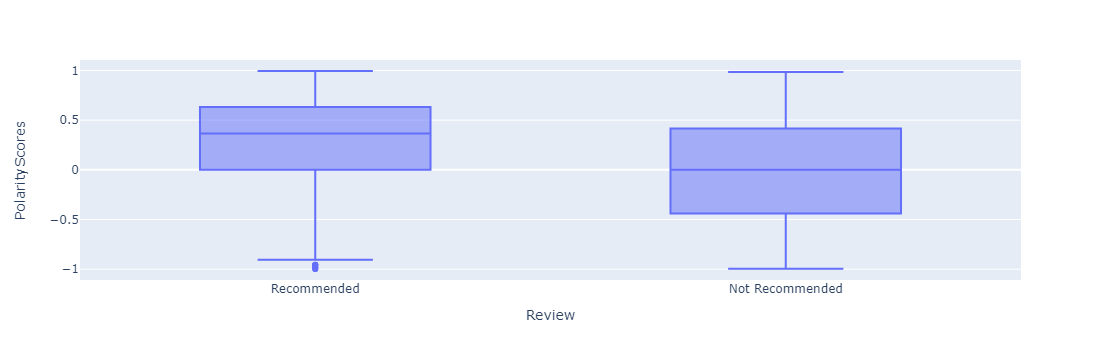

In [181]:
px.box(df, x='Review', y='PolarityScores')

## Word Cloud of Review Text

In [182]:
def plot_wordcloud(series, output_filename='wordcloud'):
    
    wordcloud = WordCloud().generate(' '.join(series.astype(str)))
    
    wordcloud.to_file(output_filename + '.png')
    
    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.axis("off")

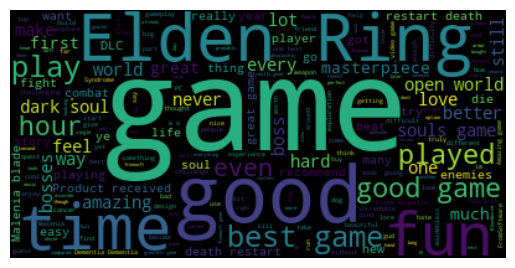

In [183]:
plot_wordcloud(df['cleanedReviewText'])